L174 - CNN to classify MNIST digits

##Structure of our MNIST CNN:

|Image Input|----Conv1----|---MaxPool1---|----Conv2----|---MaxPool2---|----FC1----|Prediction Output|
|:---:|:--:|:---:|:---:|:---:|:---:|:---:|
|1x28x28|10x26x26|10x13x13|20x11x11|20x5x5|1x50|1x10|
|       |10 feature maps        | 2x2 pooling        | 20 feature maps        |2x2 pooling|<--vectorise the MaxPool2 (to 500) and reduce to 50|predict [0-9]

(code below is from `DUDL_CNN_CNN4MNIST.ipynb`)

In [9]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import data, process to make data image-like...

In [10]:
data = np.loadtxt(open('mnist_10k.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# NEW: reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)


In [11]:
dataNorm.shape

(10000, 1, 28, 28)

Create train/test groups using DataLoader...

In [12]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
# check size -should be [ images ,Channels ,W, H ]
train_loader.dataset.tensors[0].shape

torch.Size([9000, 1, 28, 28])

# Create CNN model

 - we add code to the forward pass, that can **print** info about the model. The default is false, but this can be toggled on with a boolean 'printtoggle' argument
 - the **pooling** layers are not in the **\_\_init\_\_** method, rather they are in the **forward** method (arbitrary (they *can* be in \_\_init\_\_), but they are really just 'actions' on the data)  

In [14]:
def fnCalcConv2dSize( inSize , kernelSize , stride , padding ):
    return int( (inSize - kernelSize + 2*padding) / stride ) + 1

# test the function
for insize in [28,32,64,128,256,512]:
    for kernelSize in [3,5,7]:
        for stride in [1,2,3]:
            for padding in [0,1,2,3]:
                if fnCalcConv2dSize( insize , kernelSize , stride , padding ) == insize:
                    print( f"Input: {insize} Kernel: {kernelSize} 
                          Stride: {stride} Padding: {padding} 
                          Output: {fnCalcConv2dSize( insize , kernelSize , stride , padding )}" )
    

Input: 28 Kernel: 3 Stride: 1 Padding: 1 Output: 28
Input: 28 Kernel: 5 Stride: 1 Padding: 2 Output: 28
Input: 28 Kernel: 7 Stride: 1 Padding: 3 Output: 28
Input: 32 Kernel: 3 Stride: 1 Padding: 1 Output: 32
Input: 32 Kernel: 5 Stride: 1 Padding: 2 Output: 32
Input: 32 Kernel: 7 Stride: 1 Padding: 3 Output: 32
Input: 64 Kernel: 3 Stride: 1 Padding: 1 Output: 64
Input: 64 Kernel: 5 Stride: 1 Padding: 2 Output: 64
Input: 64 Kernel: 7 Stride: 1 Padding: 3 Output: 64
Input: 128 Kernel: 3 Stride: 1 Padding: 1 Output: 128
Input: 128 Kernel: 5 Stride: 1 Padding: 2 Output: 128
Input: 128 Kernel: 7 Stride: 1 Padding: 3 Output: 128
Input: 256 Kernel: 3 Stride: 1 Padding: 1 Output: 256
Input: 256 Kernel: 5 Stride: 1 Padding: 2 Output: 256
Input: 256 Kernel: 7 Stride: 1 Padding: 3 Output: 256
Input: 512 Kernel: 3 Stride: 1 Padding: 1 Output: 512
Input: 512 Kernel: 5 Stride: 1 Padding: 2 Output: 512
Input: 512 Kernel: 7 Stride: 1 Padding: 3 Output: 512


In [15]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,6,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26    26/2 (maxpool) = 13 after pooling
      # (the pooling layer is not here, but is in the forward method)

      self.conv2 = nn.Conv2d(6,12,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11     , 11/2(maxpool) = 5 after pooling
      # pooling layer is not here but is in forward method

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has '0' padding and '1' kernel
      expectSize = 12*int(expectSize**2)  #12 feature maps x pixels x pixels

      self.fc1 = nn.Linear(expectSize,24)   ### fully-connected layer

      self.out = nn.Linear(24,10)           ### output layer

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      if self.print: print(f'Input: {x.shape}')

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2)) #2x2 pooling
      if self.print: print(f'Layer conv1/pool1: {x.shape}')

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2)) #2x2 pooling
      if self.print: print(f'Layer conv2/pool2: {x.shape}')

      # reshape (vectorise) for linear layer
      nUnits = x.shape.numel()/x.shape[0]   # takes into account batch size
      x = x.view(-1,int(nUnits))            # flatten
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [16]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True) #<---with printtoggle ON

X,y = next(iter(train_loader))  #grab data
yHat = net(X)                   #pass thru model

print('\n sizes of model outputs and target variable: \n')
print(yHat.shape)
print(y.shape)

# ensure loss function works!
loss = lossfun(yHat,y)
print('\n Loss: ',loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 6, 13, 13])
Layer conv2/pool2: torch.Size([32, 12, 5, 5])
Vectorize: torch.Size([32, 300])
Layer fc1: torch.Size([32, 24])
Layer out: torch.Size([32, 10])

 sizes of model outputs and target variable: 

torch.Size([32, 10])
torch.Size([32])

 Loss:  tensor(2.3028, grad_fn=<NllLossBackward0>)


In [17]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 6, 13, 13])
Layer conv2/pool2: torch.Size([2, 12, 5, 5])
Vectorize: torch.Size([2, 300])
Layer fc1: torch.Size([2, 24])
Layer out: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 26, 26]           156
├─Conv2d: 1-2                            [-1, 12, 11, 11]          1,812
├─Linear: 1-3                            [-1, 24]                  7,224
├─Linear: 1-4                            [-1, 10]                  250
Total params: 9,442
Trainable params: 9,442
Non-trainable params: 0
Total mult-adds (M): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.04
Estimated Total Size (MB): 0.08


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 26, 26]           156
├─Conv2d: 1-2                            [-1, 12, 11, 11]          1,812
├─Linear: 1-3                            [-1, 24]                  7,224
├─Linear: 1-4                            [-1, 10]                  250
Total params: 9,442
Trainable params: 9,442
Non-trainable params: 0
Total mult-adds (M): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.04
Estimated Total Size (MB): 0.08

Create a function that trains the model...

In [21]:
def function2trainTheModel():
  numepochs = 40

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet() #<---note printtoggle FALSE (not set to True!)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  for epochi in range(numepochs):
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:   #batch loop

      yHat = net(X)            #forward pass
      loss = lossfun(yHat,y)   #loss

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
      # end of batch loop...

    trainAcc.append( np.mean(batchAcc) )  #1 per epoch
    losses[epochi] = np.mean(batchLoss)   #1 per epoch

    # calc. accuracy on TEST data
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():         # deactivate autograd
      yHat = net(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    print('epoch: ',epochi)
  return trainAcc,testAcc,losses,net


TRAIN model, show results...

In [22]:
trainAcc,testAcc,losses,net = function2trainTheModel()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39


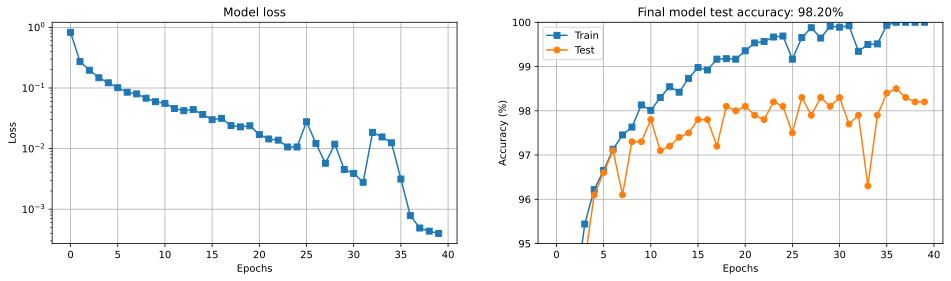

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].set_yscale('log') #<--log scale
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('Accuracy (%)')
ax[1].grid(True)
ax[1].set_ylim(95, 100)
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

# Show only integers on the x-axis
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True)) #<--integer ticks

plt.show()